In [ ]:
# Yikai Mao

# analysis/image maker

In [4]:
import sys
import os
import fnmatch
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, qpy
from qiskit_aer import AerProvider, AerSimulator
from qiskit.visualization import *
from qiskit.circuit import Parameter
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate, EfficientSU2, ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.extensions import Initialize

# other libraries
import time
import math
import pickle
from random import sample, choice
import numpy as np
from numpy import pi
import networkx as nx
from tqdm import tqdm # use: tqdm(iterable)
import matplotlib.pyplot as plt

print('-'*44)
print("available simulators:")
display(AerProvider().backends())
print('-'*44)
print("available simulation methods:")
display(AerSimulator().available_methods())
print('-'*44)
print("available devices:")
display(AerSimulator().available_devices())
print('-'*44)

env: PYTHONHASHSEED=0
--------------------------------------------
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

--------------------------------------------
available simulation methods:


('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop',
 'tensor_network')

--------------------------------------------
available devices:


('CPU', 'GPU')

--------------------------------------------


In [404]:
# utility functions

def run_ideal_simulation(circuit, device, shots, optimization_level, seed, verbose):
    # assume perfect device with no noise
    # circuit = circuit to simulate, NOT transpiled
    # device = 'CPU' or 'GPU'
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # verbose = T/F

    if device == 'GPU':
        simulator = AerSimulator(device='GPU', cuStateVec_enable=True)
    elif device == 'CPU':
        simulator = AerSimulator(device='CPU')

    if verbose:
        print('---------------------------------------START')
        print('simulator name =', simulator.configuration().to_dict()['backend_name'])
        print('max supported #qubits =', simulator.configuration().to_dict()['n_qubits'])

        print('#qubits of circuit =', circuit.num_qubits)
        print('#clbits of circuit =', circuit.num_clbits)

    if circuit.num_qubits > simulator.configuration().to_dict()['n_qubits']:
        print('too many qubits for the simulator!')
        print('----------------------------------------FAIL')
        return None

    trans_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job = simulator.run(trans_qc, shots=shots, seed_simulator=seed)
    result = job.result()

    if verbose:
        print('-------------------------------------SUCCESS')
    
    return result

def sim_result_analysis(sim_result, sort, show_plot, show_counts, verbose):
    # show_plot = T/F, plot result
    # show_counts = T/F, show sorted counts

    result_dict = sim_result.to_dict()

    if result_dict['status'] != 'COMPLETED':
        print(result_dict['status'])
        return

    device = result_dict['results'][0]['metadata']['device']
    # https://qiskit.org/ecosystem/aer/howtos/running_gpu.html
    device_time = result_dict['metadata']['time_taken_execute']
    total_time = sim_result.time_taken
    sim_time = [device, device_time, total_time]

    if verbose:
        print('device =', device)
        print('device time =', device_time)
        print('total time =', total_time)

    # build simulation result dict
    try:
        raw_counts = sim_result.get_counts()
    except:
        print('result error, output has no counts')
        return
    
    if sort:
        sorted_counts = {}
        # print("raw counts:\n", raw_counts)
        num_clbits = result_dict['results'][0]['metadata']['num_clbits']
        # sorting the raw counts, add state zero
        for i in range(pow(2, num_clbits)):
            bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
            if bin_str not in raw_counts:
                sorted_counts[bin_str] = 0
            else:
                sorted_counts[bin_str] = raw_counts[bin_str]
    else:
        sorted_counts = raw_counts

    if show_plot:
        plot = plot_histogram(sorted_counts, title='ideal simulation (sorted)')
        display(plot)
        
    if show_counts:
        print('sorted counts:')
        print(sorted_counts)

    return sim_time, raw_counts, sorted_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

def show_circuit(circuit, decompose_level, output = 'mpl', style="iqp-dark"):

    # output = text, mpl, latex, latex_source
    # style = iqp, iqp-dark, textbook, bw, clifford
    display(decomposer(circuit, decompose_level).draw(output = output, style=style))

    return None

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

In [84]:
# https://stackoverflow.com/questions/1724693/find-a-file-in-python
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [85]:
# https://stackoverflow.com/questions/72723928/how-to-combine-several-images-to-one-image-in-a-grid-structure-in-python
def combine_images(columns, space, images):
    rows = len(images) // columns
    if len(images) % columns:
        rows += 1
    width_max = max([Image.open(image).width for image in images])
    height_max = max([Image.open(image).height for image in images])
    background_width = width_max*columns + (space*columns)-space
    background_height = height_max*rows + (space*rows)-space
    background = Image.new('RGBA', (background_width, background_height), (255, 255, 255, 255))
    x = 0
    y = 0
    for i, image in enumerate(images):
        img = Image.open(image)
        x_offset = int((width_max-img.width)/2)
        y_offset = int((height_max-img.height)/2)
        background.paste(img, (x+x_offset, y+y_offset))
        x += width_max + space
        if (i+1) % columns == 0:
            y += height_max + space
            x = 0
            
    return background
    #background.save('image.png')

In [7]:
title = ['deutsch_jozsa', 'bernstein_vazirani', 'simon', 
         'grover', 'quantum_counting', 'quantum_walk', 
         'qft', 'qpe', 'shor', 
         'quantum_key_distribution', 'superdense_coding', 'quantum_teleportation', 
         'qaoa', 'vqe', 'vqc']

# Algorithms

In [314]:
def db_circuits_analysis(circuits_list, decompose_level=0):
    
    count = 0
    depth_list = []
    u_list = []
    cx_list = []
    measure_list = []
    num_qubits_list = []
    
    for circuit in tqdm(circuits_list):
        
        before = time.time()
        circuit = decomposer(circuit, decompose_level)
        after = time.time()
        
        depth_list.append(circuit.depth())
        num_qubits_list.append(circuit.num_qubits)
        
        circuit_ops = circuit.count_ops()
        
        if 'u' in circuit_ops:
            u_list.append(circuit_ops['u'])
        else:
            u_list.append(0)
            
        if 'cx' in circuit_ops:
            cx_list.append(circuit_ops['cx'])
        else:
            cx_list.append(0)
            
        if 'measure' in circuit_ops:
            measure_list.append(circuit_ops['measure'])
        else:
            measure_list.append(0)
            
        count = count + 1
        
        if after - before >= 100: # set to larger number to allow more processing time
            print('TIMEOUT (100s) at circuit '+str(count-1)+
                  ', circuit saved.')
            break
        
    return count, depth_list, u_list, cx_list, measure_list, num_qubits_list

def plot_analysis(dpi, name, count, depth_list, u_list, cx_list, measure_list, num_qubits_list):
    
    fig, ax1 = plt.subplots(figsize=(5,4), dpi=dpi)
    ax1.grid(axis='x', color="dimgray", linestyle='dashed', linewidth=0.8)

    ax1.set_title(name, fontsize='x-large') ###############################
    ax1.set_xlabel('problem size', fontsize='large')
    
    ax1.set_ylabel('#Measure  /  width', fontsize='large') ###############################
    ax1.yaxis.get_major_locator().set_params(integer=True)
    
    x = list(range(2, count+2)) # to match problem size
    # x = [i[0] for i in num_qubits_list]
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    if name == 'shor':
        ax1.set_xlabel('N', fontsize='large')
        x = [15, 21, 35, 39, 51, 55, 57, 65, 69, 77, 85, 87, 91, 93, 95, 105, 111, 115, 119, 123]
        # remove some ticks so the x axis looks cleaner
        ax1.set_xticks([15, 21, 35, 39, 51, 57, 65, 69, 77, 85, 91, 95, 105, 115, 123])
        ax1.tick_params(axis='x', labelrotation=60, which='both', labelbottom=True)
    
    ax1.plot(x, measure_list, linewidth=2, label='measure', color='indigo', linestyle='dashed', dashes=[4,3])
    ax1.plot(x, num_qubits_list, linewidth=2, label='width', color='gold', linestyle='dashed', dashes=[4,5])
    ax1.legend(loc=[0.00, 0.85],fontsize='medium',framealpha=0)
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('#U  /  #CNOT  /  depth', fontsize='large') ###############################
    # ax.set(ylim=(0, 1), yticks=[0, 0.5, 1], xticks=[0, 25, 50])
    
    ax2.plot(x, depth_list, linewidth=2, label='depth')
    ax2.plot(x, u_list, linewidth=2, label='u')
    ax2.plot(x, cx_list, linewidth=2, label='cx')
    
    ax2.legend(loc=[0.00, 0.64],fontsize='medium',framealpha=0)
    
    return None

In [478]:
i=0

with open('dataset/'+ f"{i:02}_" + title[i] + '_circuits.qpy', 'rb') as f:
    circuit = qpy.load(f) # qpy.load() always return a list
print('#circuits =', len(circuit))

circ_min = decomposer(circuit[0], 7)
circ_max = decomposer(circuit[-1], 7)
ops_min = circ_min.count_ops()
ops_max = circ_max.count_ops()
print('#qubits =', circ_min.num_qubits, circ_max.num_qubits)
print('depth = ', circ_min.depth(), circ_max.depth())
print('#u =', ops_min['u'], ops_max['u'])
try:
    print('#cx =', ops_min['cx'], ops_max['cx'])
except:
    print('no cx')
print('#measure =', ops_min['measure'], ops_max['measure'])

#circuits = 44
#qubits = 3 46
depth =  5 5
#u = 7 93
no cx
#measure = 2 45


In [408]:
count, depth_list, u_list, cx_list, measure_list, num_qubits_list = db_circuits_analysis(circuit, decompose_level=7)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 38.58it/s]


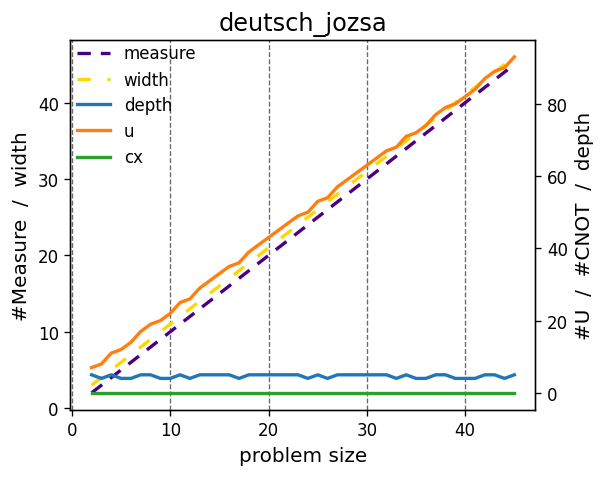

In [409]:
plot_analysis(120, title[i], count, depth_list, u_list, cx_list, measure_list, num_qubits_list)

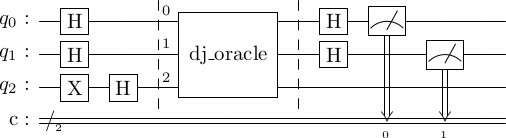

In [410]:
show_circuit(circuit[0], 0, output = 'latex', style = 'bw')

# Simulations

In [451]:
sim_device_time_cpu_lists = []

for i in list(range(len(title))):
    
    with open('sim_result_cpu/' + f"{i:02}_" + title[i] + '_sim_result.pickle', 'rb') as f:
        results = pickle.load(f)
    
    temp_device_list = []
    count = 0
    
    for result in results:

        sim_result = result
        sort = False
        show_plot = False
        show_counts = False
        verbose = False
        try:
            sim_time, raw_counts, sorted_counts = sim_result_analysis(sim_result, sort, show_plot, show_counts, verbose)
            count += 1
        except:
            print('happend at '+ title[i], count)
            break
        
        temp_device_list.append(sim_time[1])

    sim_device_time_cpu_lists.append(temp_device_list)

sim_device_time_gpu_lists = []

for i in list(range(len(title))):
    
    with open('sim_result_gpu/' + f"{i:02}_" + title[i] + '_sim_result.pickle', 'rb') as f:
        results = pickle.load(f)
    
    temp_device_list = []
    count = 0
    
    for result in results:

        sim_result = result
        sort = False
        show_plot = False
        show_counts = False
        verbose = False
        try:
            sim_time, raw_counts, sorted_counts = sim_result_analysis(sim_result, sort, show_plot, show_counts, verbose)
            count += 1
        except:
            print('happend at '+ title[i], count)
            break
        
        temp_device_list.append(sim_time[1])

    sim_device_time_gpu_lists.append(temp_device_list)

result error, output has no counts
happend at qft 30
ERROR:  [Experiment 0] a circuit requires more memory than max_memory_mb.
happend at quantum_teleportation 9
result error, output has no counts
happend at qaoa 30
result error, output has no counts
happend at vqe 30
result error, output has no counts
happend at vqc 30


In [471]:
def plot_analysis_sim(dpi, name, sim_device_time_cpu_list, sim_device_time_gpu_list):
    
    fig, ax1 = plt.subplots(figsize=(5,3), dpi=dpi)
    ax1.grid(axis='x', color="dimgray", linestyle='dashed', linewidth=0.5)
    
    ax1.set(xlabel='circuit index', ylabel='time (s)', title=name)
    ax1.yaxis.get_major_locator().set_params(integer=True)

    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    x = list(range(len(sim_device_time_gpu_list)))
    print(name, '# of GPU sims =', len(sim_device_time_gpu_list))
    ax1.plot(x, sim_device_time_gpu_list, linewidth=2, label='GPU time', color='indigo')
    # ax1.plot(x, sim_total_time_gpu_lists, linewidth=2, label='total time (gpu)', linestyle='dashed', dashes=[4,5])

    x = list(range(len(sim_device_time_cpu_list)))
    print(name, '# of CPU sims =', len(sim_device_time_cpu_list))
    ax1.plot(x, sim_device_time_cpu_list, linewidth=2, label='CPU time')
    # ax1.plot(x, sim_total_time_cpu_lists, linewidth=2, label='total time (cpu)', linestyle='dashed', dashes=[4,5])
    
    ax1.legend(loc=0 ,fontsize='medium',framealpha=0)

    # display(fig)
    
    return None

deutsch_jozsa # of GPU sims = 32
deutsch_jozsa # of CPU sims = 32
bernstein_vazirani # of GPU sims = 32
bernstein_vazirani # of CPU sims = 32
simon # of GPU sims = 16
simon # of CPU sims = 16
grover # of GPU sims = 13
grover # of CPU sims = 13
quantum_counting # of GPU sims = 6
quantum_counting # of CPU sims = 6
quantum_walk # of GPU sims = 2
quantum_walk # of CPU sims = 2
qft # of GPU sims = 30
qft # of CPU sims = 32
qpe # of GPU sims = 19
qpe # of CPU sims = 19
shor # of GPU sims = 20
shor # of CPU sims = 3
quantum_key_distribution # of GPU sims = 33
quantum_key_distribution # of CPU sims = 33
superdense_coding # of GPU sims = 33
superdense_coding # of CPU sims = 33
quantum_teleportation # of GPU sims = 9
quantum_teleportation # of CPU sims = 7
qaoa # of GPU sims = 30
qaoa # of CPU sims = 33
vqe # of GPU sims = 30
vqe # of CPU sims = 30
vqc # of GPU sims = 30
vqc # of CPU sims = 31


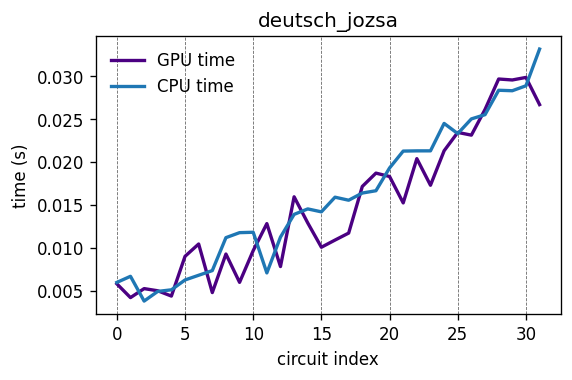

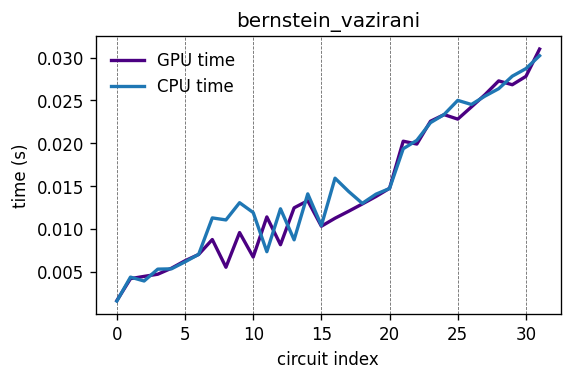

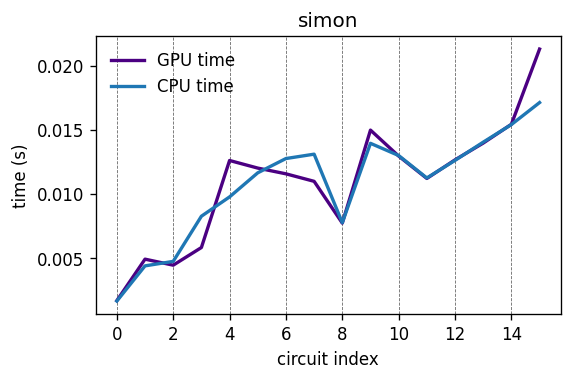

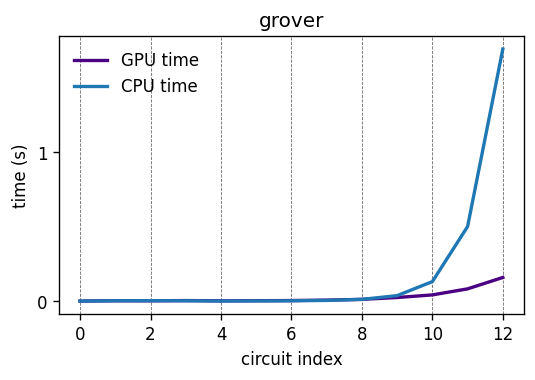

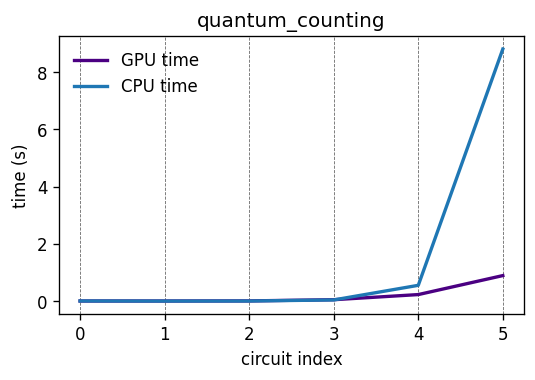

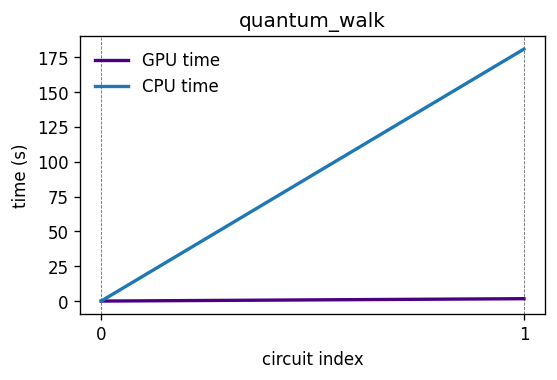

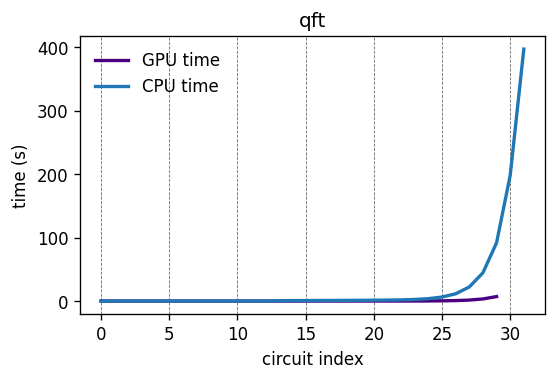

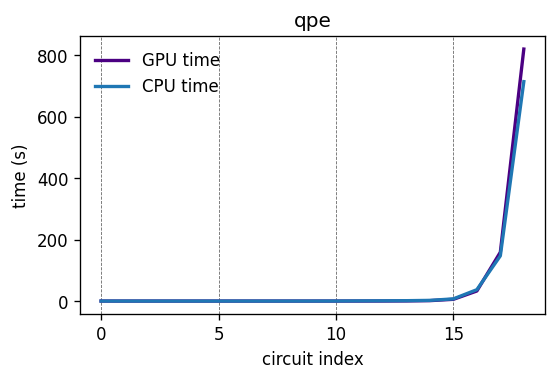

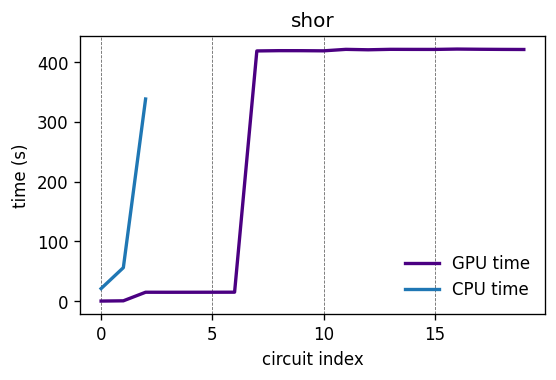

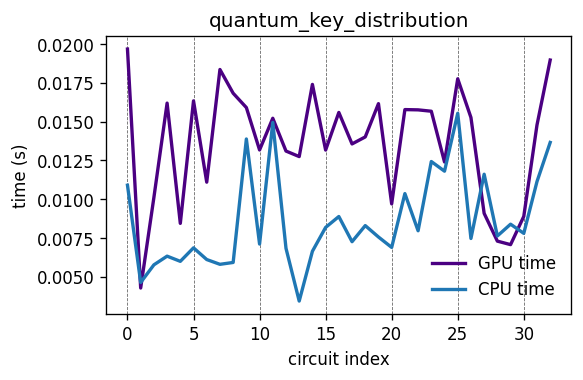

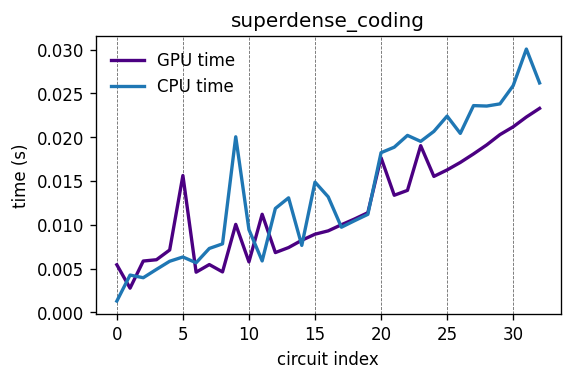

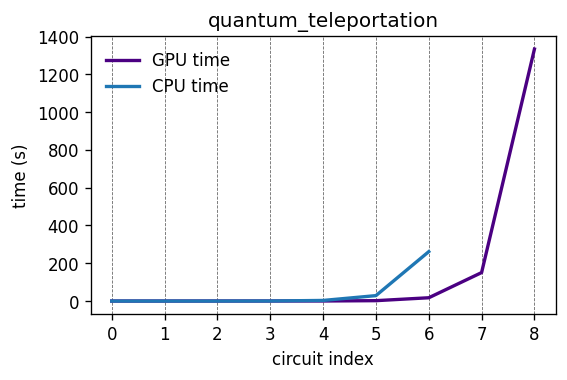

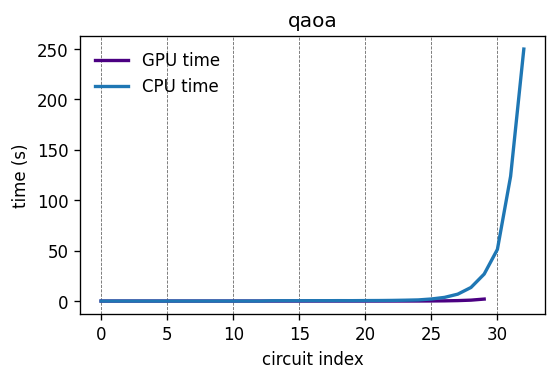

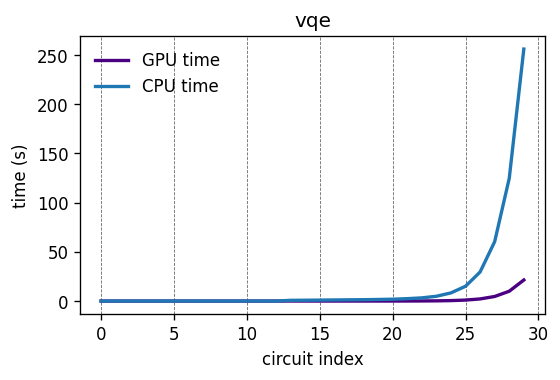

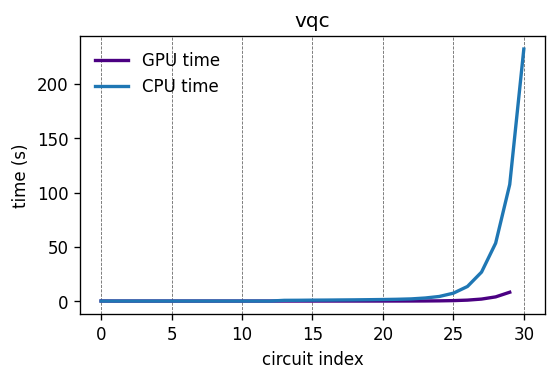

In [472]:
for i in range(len(title)):
# for i in [0,3,6,9,12]:
    plot_analysis_sim(120, title[i], sim_device_time_cpu_lists[i], sim_device_time_gpu_lists[i])